<a href="https://colab.research.google.com/github/hirokimituya/book_create-profitable-AI-with-Python/blob/main/ch04_04_estimate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 4.4 評価

In [1]:
# 日本語化ライブラリ導入
!pip install japanize-matplotlib | tail -n 1

In [2]:
# 共通事前処理

# 余分なワーニングを非表示にする
import warnings
warnings.filterwarnings('ignore')

# 必要ライブラリのimport
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# matplotlib日本語化対応
import japanize_matplotlib

# データフレーム表示用関数
from IPython.display import display

# 表示オプション調整
# numpyの浮動小数点の表示精度
np.set_printoptions(suppress=True, precision=4)
# pandasでの浮動小数点の表示精度
pd.options.display.float_format = '{:.4f}'.format
# データフレームですべての項目を表示
pd.set_option("display.max_columns",None)
# グラフのデフォルトフォント指定
plt.rcParams["font.size"] = 14
# 乱数の種
random_seed = 123

## 4.4.1 混同行列

In [3]:
from pickle import load
# データ読み込みからデータ分割まで

# ライブラリのimport
from sklearn.datasets import load_breast_cancer

# データのロード
cancer = load_breast_cancer()

# 入力データx
x = cancer.data

# 正解データy
# 良性: 0 悪性: 1に値を変換する
y = 1 - cancer.target

# 入力データを2次元に絞り込み
x2 = x[:, :2]

# (4)データ分割
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x2, y, train_size=0.7, test_size=0.3,
                                                    random_state=random_seed)

In [4]:
# アルゴリズム選択から評価まで

# アルゴリズム選択（ロジスティック回帰）
from sklearn.linear_model import LogisticRegression
algorithm = LogisticRegression(random_state=random_seed)

# 学習
algorithm.fit(x_train, y_train)

# 予測
y_pred = algorithm.predict(x_test)

# 評価
score = algorithm.score(x_test, y_test)

# 結果確認
print(f'score: {score:.4f}')

score: 0.8772


In [5]:
# 混同行列の計算

# 必要なライブラリの取り込み
from sklearn.metrics import confusion_matrix

# 混同行列の生成
# y_test: 検証データの正解データ
# y_pred: 検証データの予測結果
matrix = confusion_matrix(y_test, y_pred)

# 結果確認
print(matrix)

[[101   2]
 [ 19  49]]


In [6]:
# 混同行列表示用関数

def make_cm(matrix, columns):
    # matrix numpy配列

    # columns項目名リスト
    n = len(columns)

    # '正解データ'をn回繰り返すリスト生成
    act = ['正解データ'] * n
    pred = ['予測結果'] * n

    # データフレーム生成
    cm = pd.DataFrame(matrix, columns=[pred, columns], index=[act, columns])
    
    return cm

In [7]:
# make_cmを使った混同行列の表示
cm = make_cm(matrix, ['良性', '悪性'])
display(cm)

予測結果    
           良性  悪性
正解データ 良性  101   2
      悪性   19  49

## 4.4.2 精度・適合率・再現率・F値



* 精度（Accuracy） ... 「正解数」を「全体件数」で割った比率 (TP + TN) / (TP + FP + FN + TN)
* 適合率（Precision） ... モデルが「陽性」と予測した対象のうち、本当に「陽性」だった割合 TP / (TP + FP)
* 再現率（Recall） ... 本当に「陽性」だったデータのうち、どの程度をモデルで「陽性」と検知できたか TP / (TP + FN)
* F値（F-score） ... 適合率と再現率の調和平均 2 * (適合率) * (再現率) / ((適合率) + (再現率))




In [8]:
# 適合率・再現率・F値の計算

# ライブラリの取り込み
from sklearn.metrics import precision_recall_fscore_support

# 適合率・再現率・F値の計算
precision, recall, fscore, _ = precision_recall_fscore_support(
    y_test, y_pred, average='binary')

# 結果の確認
print(f'適合率: {precision:.4f}')
print(f'再現率: {recall:.4f}')
print(f'F値: {fscore:.4f}')

適合率: 0.9608
再現率: 0.7206
F値: 0.8235


## 4.4.3 確率値と閾値

In [9]:
# 確率値の取得
y_proba = algorithm.predict_proba(x_test)
print(y_proba[10:20, :])

[[0.7889 0.2111]
 [0.0812 0.9188]
 [0.8383 0.1617]
 [0.9391 0.0609]
 [0.369  0.631 ]
 [0.9451 0.0549]
 [0.9399 0.0601]
 [0.9494 0.0506]
 [0.9617 0.0383]
 [0.9836 0.0164]]


In [16]:
# positive(1)の確率値の取得
y_proba1 = y_proba[:, 1]

# 結果確認
print(y_test[10:20])
print(y_pred[10:20])
print(y_proba1[10:20])

[0 1 1 0 1 0 0 0 0 0]
[0 1 0 0 1 0 0 0 0 0]
[0.2111 0.9188 0.1617 0.0609 0.631  0.0549 0.0601 0.0506 0.0383 0.0164]


In [11]:
# 閾値を変化させる
thres = 0.5
print((y_proba1[10:20] > thres).astype(int))

thres = 0.7
print((y_proba1[10:20] > thres).astype(int))

[0 1 0 0 1 0 0 0 0 0]
[0 1 0 0 0 0 0 0 0 0]


In [12]:
# 閾値を変更した場合の予測関数の定義
def pred(algorithm, x, thres):
    # 確率値の取得（行列）
    y_proba = algorithm.predict_proba(x)

    # 予測結果1の確率値
    y_proba1 = y_proba[:,1]

    # 予測結果1の確率 > 閾値
    y_pred = (y_proba1 > thres).astype(int)
    return y_pred

In [13]:
# 閾値0.5で予測結果取得
pred_05 = pred(algorithm, x_test, 0.5)

# 閾値0.7で予測結果取得
pred_07 = pred(algorithm, x_test, 0.7)

# 結果確認
print(pred_05[10:20])
print(pred_07[10:20])

[0 1 0 0 1 0 0 0 0 0]
[0 1 0 0 0 0 0 0 0 0]


## 4.4.4 PR曲線とROC曲線

In [23]:
# ライブラリの導入
from sklearn.metrics import precision_recall_curve
# 適合率, 再現率、閾値の取得
precision, recall, thresholds = precision_recall_curve(
    y_test, y_proba1)
# 結果をデータフレームにする
df_pr = pd.DataFrame([thresholds, precision, recall]).T
df_pr.columns = ['閾値', '適合率', '再現率']
# 閾値 0.5の周辺を表示
display(df_pr[52:122:10])

,閾値,適合率,再現率
52,0.0322,0.5462,0.9559
62,0.0491,0.5963,0.9559
72,0.0601,0.6465,0.9412
82,0.0987,0.7191,0.9412
92,0.1602,0.8101,0.9412
102,0.2170,0.8551,0.8676
112,0.3624,0.9492,0.8235


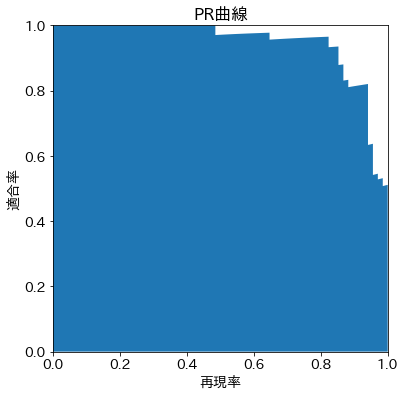

In [24]:
# 描画サイズ指定
plt.figure(figsize=(6, 6))
# グラフ領域の塗りつぶし
plt.fill_between(recall, precision, 0)
# x, yの範囲指定
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
# ラベル・タイトル表示
plt.xlabel('再現率')
plt.ylabel('適合率')
plt.title('PR曲線')
plt.show()

In [25]:
# PR曲線下面積の計算
from sklearn.metrics import auc
pr_auc = auc(recall, precision)
print(f'RP曲線下面積: {pr_auc:.4f}')

RP曲線下面積: 0.9459


In [26]:
# ROC曲線用配列の生成

# ライブラリの導入
from sklearn.metrics import roc_curve

# 偽陽性率、敏感度と閾値の取得
fpr, tpr, thresholds = roc_curve(
    y_test, y_proba1, drop_intermediate=False
)

# 結果をデータフレームにする
df_roc = pd.DataFrame([thresholds, fpr, tpr]).T
df_roc.columns = ['閾値', '偽陽性率', '敏感度']

# 閾値0.5の周辺を表示
display(df_roc[21:91:10])

,閾値,偽陽性率,敏感度
21,0.9829,0.0000,0.3088
31,0.9025,0.0000,0.4559
41,0.7763,0.0097,0.5882
51,0.5347,0.0194,0.7206
61,0.3371,0.0388,0.8382
71,0.2027,0.1165,0.8676
81,0.1473,0.1650,0.9412


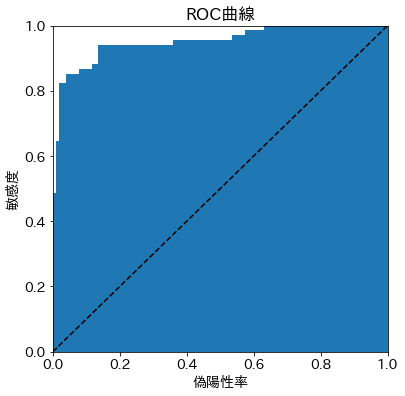

In [29]:
# ROC曲線の描画

# 描画サイズ指定
plt.figure(figsize=(6, 6))

# 点線表示
plt.plot([0, 1], [0, 1], 'k--')

# グラフ領域の塗りつぶし
plt.fill_between(fpr, tpr, 0)

# x, yの範囲指定
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

# ラベル・タイトル表示
plt.xlabel('偽陽性率')
plt.ylabel('敏感度')
plt.title('ROC曲線')
plt.show()

In [30]:
# ROC曲線下面積の計算
roc_auc = auc(fpr, tpr)
print(f'ROC曲線下面積: {roc_auc:.4f}')

ROC曲線下面積: 0.9522


## 4.4.5 入力項目の重要度

In [34]:
# ランダムフォレストのモデルを作るまで

# サンプルデータの読み込み
import seaborn as sns
df_iris = sns.load_dataset('iris')
columns_i = ['がく片長', 'がく片幅', '花弁長', '花弁幅', '種別']
df_iris.columns = columns_i

# 入力データx
x = df_iris[['がく片長', 'がく片幅', '花弁長', '花弁幅']]

# 正解データy
y = df_iris['種別']

# アルゴリズムの選択（ランダムフォレスト）
from sklearn.ensemble import RandomForestClassifier
algorithm = RandomForestClassifier(random_state=random_seed)

# 学習
algorithm.fit(x, y)

RandomForestClassifier(random_state=123)

In [36]:
# 重要度ベクトルの取得
importances =  algorithm.feature_importances_

# 項目名をキーにSeriesを生成
w = pd.Series(importances, index=x.columns)

# 値の大きい順にソート
u = w.sort_values(ascending=False)

# 結果確認
print(u)

花弁長    0.4611
花弁幅    0.4257
がく片長   0.0874
がく片幅   0.0257
dtype: float64


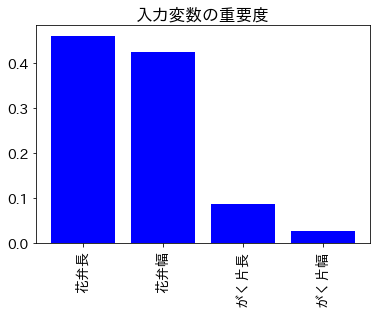

In [38]:
# 重要度の棒グラフ表示

# 棒グラフ表示
plt.bar(range(len(u)), u, color='b', align='center')

# 項目名表示（90度回転）
plt.xticks(range(len(u)), u.index, rotation=90)

# タイトル表示
plt.title('入力変数の重要度')

plt.show()

## 4.4.6 回帰の戻るの評価方法